# Understanding how Ar41 de-excitation is simulated in Geant4
In this notebook, we aim to understand how the de-excitation of Ar41 is simulated in Geant4 (G4).
The intuition by the last talk with Luciano P. is that G4 could simulate correctly the gamma emitted by the de-excitation process but it doesn't simulate the Ar41 excitation in a separate step.
Up to now, we have looked for Ar41* in the simulation by CJ but if the intuition is true, then we had looked the wrong thing.

We have looked for the process: *Ar40 + n -> Ar41 * -> Ar41 + gammas*

Maybe G4 simulate the process as: *Ar40 + n -> Ar41 + gammas*

To check this fact, we look for gammas produces during the neutron capture with Ar40 and try to understand if their kinetic energy (KE) is consistent with the literature - see tables (1).

(1) https://www-nds.iaea.org/capgam/byn/page033.html

## First step - extract the Ar41 entries in the simulated data
In the simulated data, there are 4 entries of Ar41. 
These entries are all in the event `0` and corresponds to 2 atoms with respective tracknumber (tn) `1942` and `2116`, created by the process `nCapture` as expected.

These entries are reported in the following table.

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 20})

In [1]:
fields = ["PID", "ParentTrackID", "energydeposition", "kineticenergy", "time", "x", "y", "z", "eventnumber", "tracknumber", "parentnucleusPID", "creatorprocess"]
file_path = os.path.join("..", "Data", "output_Muon_123456789.csv")
df = pd.read_csv(file_path, index_col=False)[fields]

# extract ar41 entries
ar41 = df[df.PID==1000180410]
events = ar41.eventnumber.unique()
print("[Info] Found {} entries of Ar41 in the events: {}".format(len(ar41), events))
ar41

[Info] Found 4 entries of Ar41 in the events: [0]


,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,eventnumber,tracknumber,parentnucleusPID,creatorprocess
2199,1000180410,1910,13.401300,0.0,8.471150e+02,-4.80272,-297.988,839.436,0,1942,1000180410,nCapture
2200,1000180410,1910,0.000000,0.0,1.621600e+13,-4.80273,-297.988,839.436,0,1942,1000180410,nCapture
2428,1000180410,2064,0.436831,0.0,1.022700e+05,-1847.85000,143.459,379.513,0,2116,1000180410,nCapture
2429,1000180410,2064,0.000000,0.0,5.625890e+12,-1847.85000,143.459,379.513,0,2116,1000180410,nCapture


## Second step - extract the neutron that has generated the Ar41
The neutrons that generated the 2 Ar41 atoms are identified by the tracknumber `1910` and `2064`.


In [2]:
event0 = df[df.eventnumber==0].sort_values("time")
neutrons = event0[event0.tracknumber.isin(ar41.ParentTrackID.unique())].tracknumber.unique()
print("The neutrons captured are: {}".format(neutrons))

The neutrons captured are: [1910 2064]


## Third step - look for gammas forced by those neutrons
We are interested in two neutron captures, one for each atom of Ar41:
- the first occurs at time `847.1150` and coordinates `-4.80272, -297.988, 839.436`. 
- the second occurs at time `102270.0`and coordinates `-1847.85000, 143.459, 379.513`.

We filter the gammas (PID=22) produced by the captured neutrons at that time and found 4 gammas, 2 of them forced by the first neutron and 2 of them forced by the second neutron.

The first entry of each of these gammas is reported here:

In [3]:
gammas = event0[(event0.PID==22) & (event0.ParentTrackID.isin(neutrons))]
gammas.groupby("tracknumber").first()

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,eventnumber,parentnucleusPID,creatorprocess
tracknumber,,,,,,,,,,,
1940,22,1910,0.0,3993.1500,847.722,-4.80272,-297.988,839.436,0,0,nCapture
1941,22,1910,0.0,142.9320,847.172,-4.80272,-297.988,839.436,0,0,nCapture
2114,22,2064,0.0,5931.2400,102270.000,-1847.85000,143.459,379.513,0,0,nCapture
2115,22,2064,0.0,97.6891,102270.000,-1830.78000,135.336,359.665,0,0,nCapture


## Observations:
- these gammas are **produced slightly later** the respective Ar41 atom.
- the **coordinates** in which the gammas are created is **the same** as the respective Ar41 atom.
- in each neutron capture, there are **2 gammas**: one with KE in O(MeV), one with KE in O(10keV).

# Plot of the two neutron-capture events
In this section, we plot the simulated data after the neutron capture. We particularly focus on where the capture happened (*blue dot*), the gamma emitted from the capture and their trajectory until the photoelectric (*green line*) and the eventual electrons released by Compton scattering (*red stars*). The size of the stars is proportional to the deposited energy.

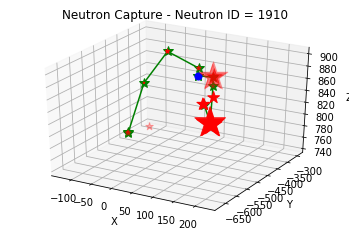

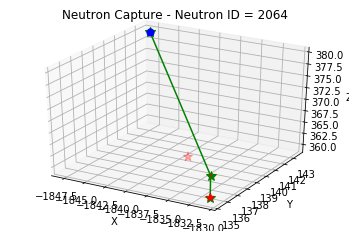

In [4]:
for i, neutron in enumerate(neutrons):
    fig = plt.figure(i+1)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Neutron Capture - Neutron ID = {}".format(neutron))
    # plot the neutron capture
    x0, y0, z0 = ar41[ar41.ParentTrackID==neutron][["x", "y", "z"]].iloc[0]
    ax.scatter(x0, y0, z0, c='b', marker='.', s=200)
    # track each gamma
    gammas_tns = event0[(event0.ParentTrackID==neutron) & (event0.PID==22)].tracknumber.unique()
    for gamma in gammas_tns:
        gamma_track = event0[event0.tracknumber == gamma].sort_values("time")            
        X, Y, Z = gamma_track.x, gamma_track.y, gamma_track.z    # gamma-track coordinate        
        electrons = event0[event0.ParentTrackID == gamma].sort_values(["time", "tracknumber"])
        Xe, Ye, Ze, Ee = electrons.x, electrons.y, electrons.z, electrons.energydeposition    
        # plot the gamma track
        ax.plot(X, Y, Z, c='g', marker='*', markersize=10)
        # plot the compton scattering
        ax.scatter(Xe, Ye, Ze, c='r', marker='*', s=Ee)
plt.show()

## Anomalies:
- The **second capture** (*Neutron ID=2064*) is weird. It emits 2 gammas but the one with highest KE (*tn=2114*) disappeares from the rest of the simulation. There is not any compton/photoelectric process associated with this gamma. (**why?!**)

The filter of this gamma in the event `0` is reported in the following.

In [5]:
event0[event0.tracknumber==2114]

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,eventnumber,tracknumber,parentnucleusPID,creatorprocess
2404,22,2064,0.0,5931.24,102270.0,-1847.85,143.459,379.513,0,2114,0,nCapture


In [6]:
time_window = 1000    # ns
time_min, time_max = 102270 - time_window, 102270 + time_window
event0[(event0.PID==22) & (event0.time >= time_min) & (event0.time <= time_max)].sort_values("time")

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,eventnumber,tracknumber,parentnucleusPID,creatorprocess
2399,22,2064,0.0000,97.6891,102270.0,-1830.78,135.336,359.665,0,2115,0,nCapture
2400,22,2064,3.2063,0.0000,102270.0,-1832.45,136.787,361.731,0,2115,0,nCapture
2404,22,2064,0.0000,5931.2400,102270.0,-1847.85,143.459,379.513,0,2114,0,nCapture
2398,22,2064,0.0000,101.5040,102270.0,-1847.85,143.459,379.513,0,2115,0,nCapture


[Info] Event 0 loaded. All entries: 2670
Plot only muons, electrons, neutrons, photons


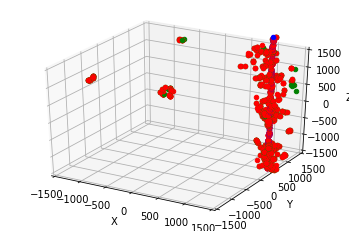

In [7]:
%run -i ../Development/plot_event.py 0


In [8]:
event0[event0.ParentTrackID==2114]

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,eventnumber,tracknumber,parentnucleusPID,creatorprocess


## Looking Gamma production from Ar41 de-excitation
In this section, we aim to verify the high-energy gamma production from Ar41 de-excitation.
The filtering of this specific process is not trivial, we proceed in the following way:
1. We filter all the entries from CJ simulations with creator process `nCapture`.
1. Since neutron capture not always invoves Ar40 and produce Ar41, we filter all the Ar41 occurrences keeping the fields `eventnumber` and `ParentTrackID`. Note that the latter identifies the neutron particles that hit Ar40 and produced Ar41.
1. We filter all the gammas entries (`PID==22`).
1. Since the entries present repeatition for the same gammas (*ndr: because they are sim steps*), we grouped the entries for each gamma (`key: eventnumber, tracknumber`) and keep the first gamma entry w.r.t. `time`.
1. Finally, we merged the dataset of `first_gammas` with the neutron-capture events that produced Ar41.

In [5]:
import numpy as np, pandas as pd
import os

datadir = os.path.join("..", "Data", "muons")
filename = "FilterNCaptureEntries.csv"

# 1. Load all entries wt creator process `nCapture`
ncapt_entries = pd.read_csv(os.path.join(datadir, filename), index_col=False)
# 2. Collect `eventnumber` and `ParentTrackID` (i.e., neutron's tracknumber) from Ar41 entries
#    the others are not related to Ar41 deexcitation
id_ncapt_wt_ar41 = ncapt_entries[ncapt_entries.PID == 1000180410][["eventnumber", "ParentTrackID"]]
id_ncapt_wt_ar41["neutron_id"] = id_ncapt_wt_ar41.eventnumber.astype(str) + " " + id_ncapt_wt_ar41.ParentTrackID.astype(str)
id_ncapt_wt_ar41_list = id_ncapt_wt_ar41.neutron_id.unique()
# 3. Filter all gammas
gammas = ncapt_entries[ncapt_entries.PID==22].sort_values("time")
# 4. Keep first entry (w.r.t. time) for each gamma particle
first_gammas = gammas.groupby(["eventnumber", "tracknumber"]).first().reset_index()    # first w.r.t. time
first_gammas["neutron_id"] = first_gammas.eventnumber.astype(str) + " " + first_gammas.ParentTrackID.astype(str)
# 5. Keep only gammas produced by Ar41 de-excitation
first_gammas_ar41deex = first_gammas[first_gammas.neutron_id.isin(id_ncapt_wt_ar41_list)]

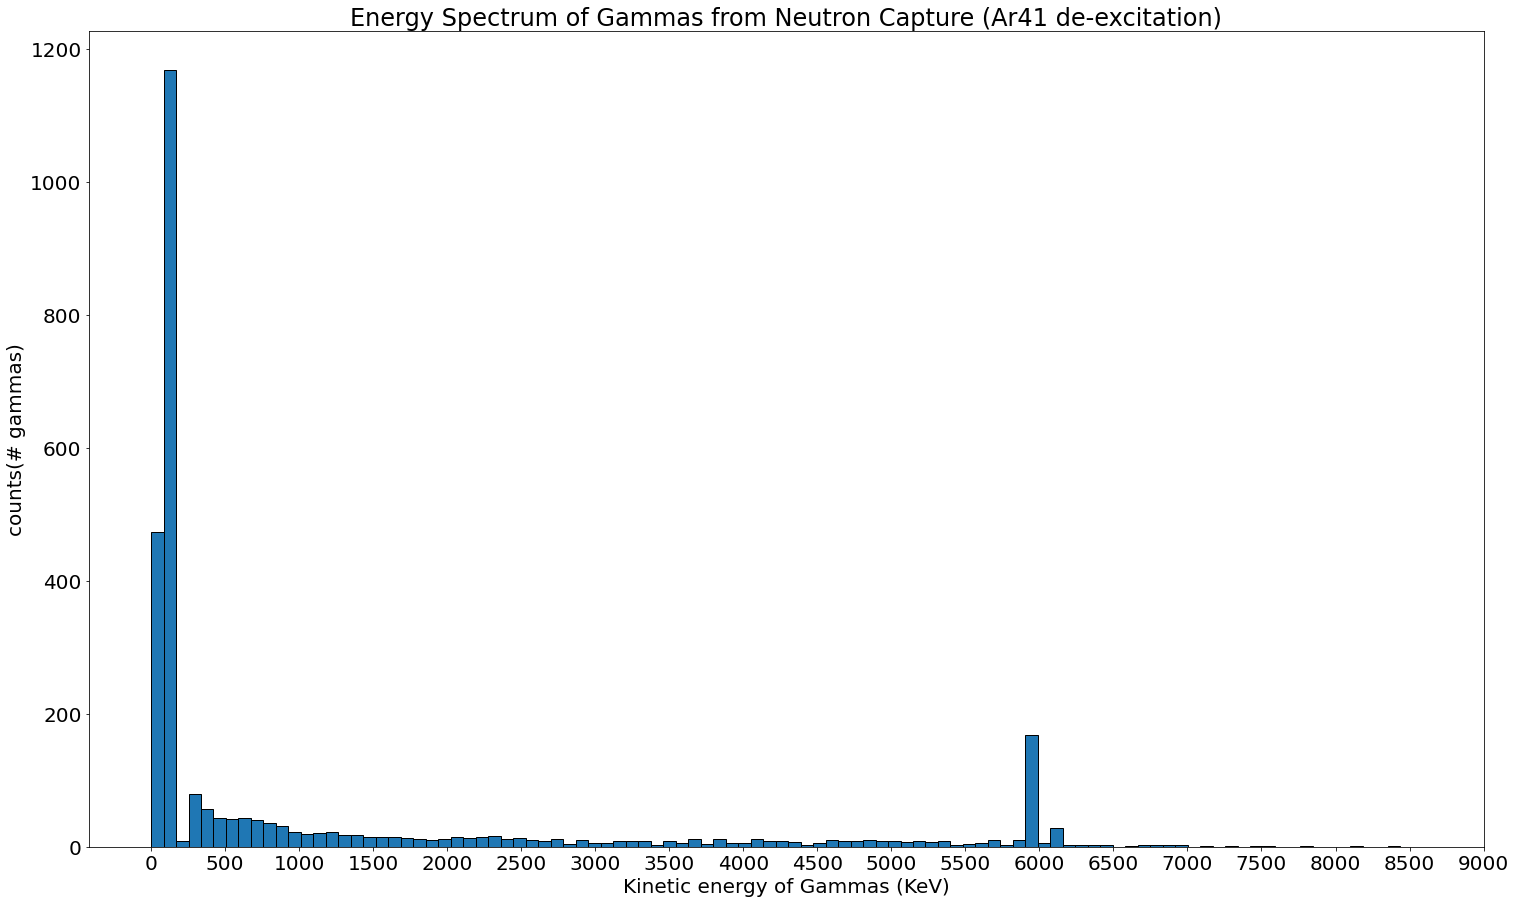

In [9]:
plt.hist(first_gammas_ar41deex.kineticenergy, bins=100, edgecolor='k')
plt.xlabel("Kinetic energy of Gammas (KeV)")
plt.ylabel("counts(# gammas)")
plt.title("Energy Spectrum of Gammas from Neutron Capture (Ar41 de-excitation)")
plt.xticks(np.linspace(0, 9000, 19))
plt.show()

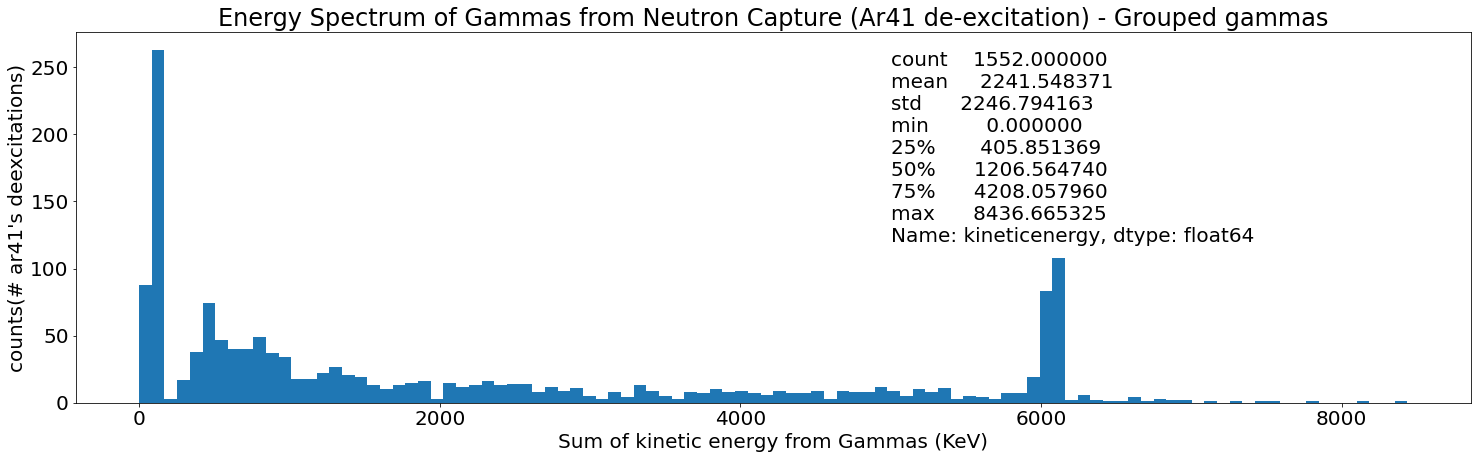

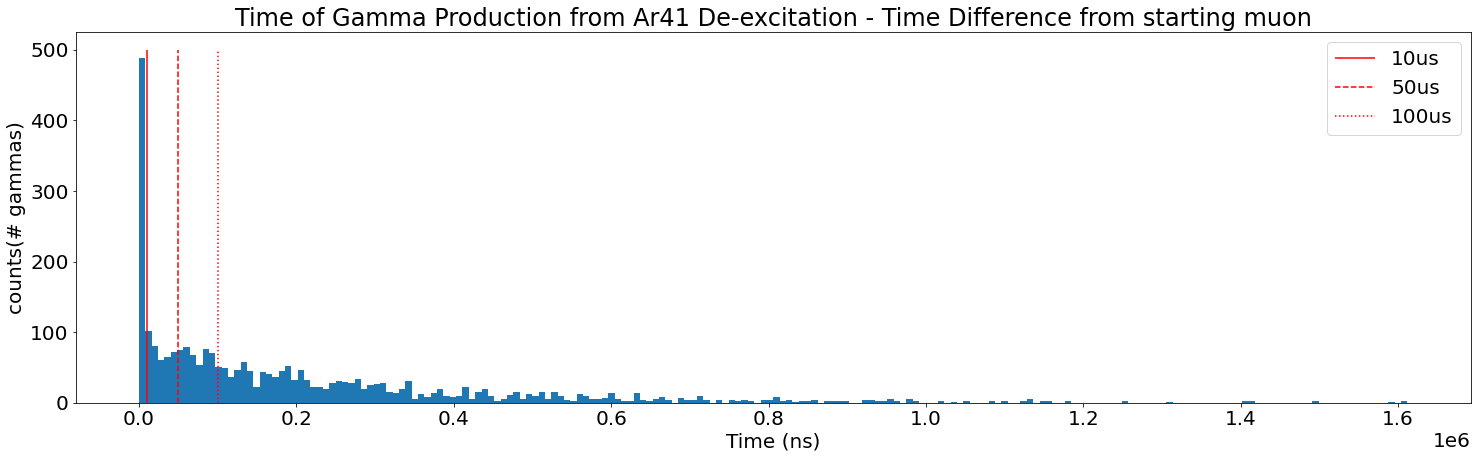

In [30]:
sum_gamma_ke_for_ar41deex = first_gammas_ar41deex.groupby("neutron_id").kineticenergy.sum()
plt.subplot(2, 1, 1)
plt.hist(sum_gamma_ke_for_ar41deex, bins=100)
plt.title("Energy Spectrum of Gammas from Neutron Capture (Ar41 de-excitation) - Grouped gammas")
plt.xlabel("Sum of kinetic energy from Gammas (KeV)")
plt.ylabel("counts(# ar41's deexcitations)")
plt.text(5000, 120, str(sum_gamma_ke_for_ar41deex.describe()))
plt.show()

plt.subplot(2, 1, 2)
plt.hist(first_gammas_ar41deex.time, bins=200)
plt.vlines(x=10*1000, ymin=0, ymax=500, label="10us", color='r', linestyles='solid')
plt.vlines(x=50*1000, ymin=0, ymax=500, label="50us", color='r', linestyles='dashed')
plt.vlines(x=100*1000, ymin=0, ymax=500, label="100us", color='r', linestyles='dotted')
plt.title("Time of Gamma Production from Ar41 De-excitation - Time Difference from starting muon")
plt.xlabel("Time (ns)")
plt.ylabel("counts(# gammas)")
#plt.text(5000, 150, str(sum_gamma_ke_for_ar41deex.describe()))
plt.legend()
plt.show()


In [15]:
first_gammas_ar41deex.time.describe()

count    2.842000e+03
mean     1.993760e+05
std      2.358676e+05
min      4.385927e+01
25%      2.881387e+04
50%      1.189341e+05
75%      2.802059e+05
max      1.611853e+06
Name: time, dtype: float64

In [103]:
ncapt_entries[(ncapt_entries.eventnumber==2357) & (ncapt_entries.ParentTrackID==175034)].sort_values("time")

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID
48200,1000180410,175034,63.392261,0.000000,7.377577e+01,-263.238251,-1848.924211,901.393414,0.972886,0.228389,-0.036498,2357,175039,nCapture,1000180410
48213,22,175034,0.000000,8120.366669,7.417497e+01,-355.296288,-1917.358743,867.106231,-0.768926,-0.571608,-0.286388,2357,175038,nCapture,0
48201,1000180410,175034,0.000000,0.000000,6.072496e+12,-263.238251,-1848.924211,901.393414,0.972886,0.228389,-0.036498,2357,175039,nCapture,1000180410


In [104]:
first_gammas[(first_gammas_ar41deex.eventnumber==2357) & (first_gammas_ar41deex.ParentTrackID==175034)]


,eventnumber,tracknumber,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,creatorprocess,parentnucleusPID
556,2357,175038,22,175034,0.0,8120.366669,74.174972,-355.296288,-1917.358743,867.106231,-0.768926,-0.571608,-0.286388,nCapture,0
557,2357,175038,22,175034,0.0,8120.366669,74.174972,-355.296288,-1917.358743,867.106231,-0.768926,-0.571608,-0.286388,nCapture,0
